# Data Imputation with MICE

In [18]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge # A common estimator for IterativeImputer
import h5py
import os 
import math 
from scipy.spatial import cKDTree
import geopandas as gpd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from scipy.interpolate import griddata
from shapely.geometry import Point


In [2]:
# Function to generate the grid points
def generate_grid_points(top_left_lat, top_left_lon, bottom_right_lat, bottom_right_lon, grid_size):
    grid_points = []

    # Calculate the distance between the top-left and bottom-right corners
    lat_distance = abs(top_left_lat - bottom_right_lat)
    lon_distance = abs(top_left_lon - bottom_right_lon)

    # Calculate the number of grids in latitude and longitude directions
    num_lat_grids = int(lat_distance * 111.32 / grid_size)  # 1 degree latitude ~ 111.32 km
    num_lon_grids = int(lon_distance * 111.32 * math.cos(math.radians(top_left_lat)) / grid_size)

    # Generate grid points
    for i in range(num_lat_grids + 1):
        for j in range(num_lon_grids + 1):
            lat = top_left_lat - (i * grid_size / 111.32)
            lon = top_left_lon + (j * grid_size / (111.32 * math.cos(math.radians(top_left_lat))))
            grid_points.append((lat, lon))

    return grid_points

def list_files(directory: str, ftype):
    """
    List files all file in given folder.

    Parameters:
        directory (str): Directory to search for files.
        
    Returns:
        dict: A dictionary where keys are week ranges and values are lists of matching files.
    """
    matching_files = []
    matching_files.extend(
        [directory+"/"+f for f in os.listdir(directory) if f.endswith(ftype)]
    )
    #files_by_week[f"{start} to {stop}"] = matching_files

    return matching_files

def load_combined_file(file_path):
    """
    Load the combined HDF5 file and extract the data.
    """
    print(file_path)
    with h5py.File(file_path, 'r') as f:
        soil_moisture = f['soil_moisture'][:]
        latitude = f['latitude'][:]
        longitude = f['longitude'][:]
    return soil_moisture, latitude, longitude

def genSMAP(filtered_stations, smap_locations, _smapDf, paraName):
    tele_locations = filtered_stations[['latitude', 'longitude']].to_numpy()
    tele_values = filtered_stations['val'].to_numpy()
    
    #print(tele_locations, tele_values)
    
    smap_tree = cKDTree(smap_locations)
    
    # Keep track of used locations in smapDf
    used_smap_indices = set()
    
    # Prepare a column to store results
    _smapDf[paraName] = np.nan  # New column for matched SMAP values
    
    
    # Iterate over each smap location and match it to the nearest tele location
    for idx, tele_loc in enumerate(tele_locations):
        # Query the nearest tele location
        #distance, tele_idx = tele_tree.query(tele_loc)
        distance, smap_idx = smap_tree.query(tele_loc)
        #print(distance, smap_idx,idx , tele_loc, smap_locations[smap_idx])
    
        if smap_idx not in used_smap_indices:
            _smapDf.loc[smap_idx, paraName] = tele_values[idx]
            #print(distance, smap_idx,idx , tele_loc, smap_locations[smap_idx],tele_values[idx], smapDf['matched_smap_val'][idx])
            used_smap_indices.add(smap_idx)  # Mark this SMAP index as used
    
    #print(smapDf)
    return _smapDf

def ReadData(csv_file, lat, lon, PlotLocation=False):
    # Determine the bounding box of the SMAP data
    lat_min, lat_max = min(lat), max(lat)
    lon_min, lon_max = min(lon), max(lon)

    # Load telemetry station data (CSV format assumed)
    #tele_data = pd.read_csv(csv_file, names=['code','latitude','longitude','val'])
    tele_data = pd.read_csv(csv_file)
    #print(tele_data)

    if (PlotLocation):
        # Plot Position
        plotTheMap(tele_data, "TelePosition", gdf_province)

    # Filter telemetry stations within SMAP bounding box
    filtered_stations = tele_data[
        (tele_data['latitude'] >= lat_min) & (tele_data['latitude'] <= lat_max) &
        (tele_data['longitude'] >= lon_min) & (tele_data['longitude'] <= lon_max)
    ]
    return filtered_stations
# Convert dataframes into structured grid format
def prepare_data(dfs):
    X = []
    #for _df in dfs:
        
    #val_grid = interpolate_feature(dfs, 'val')
    
    # Applying IDW to interpolate rain data on grid
    humid_grid = inverse_distance_weighting(
        dfs['latitude'].values,
        dfs['longitude'].values,
        dfs['humid'].values,
        lat_grid,
        lon_grid
    )
    
    #dfs['humid_idw'] = humid_grid
    
    rain_grid = inverse_distance_weighting(
        dfs['latitude'].values,
        dfs['longitude'].values,
        dfs['rain'].values,
        lat_grid,
        lon_grid
    )
    temp_grid = inverse_distance_weighting(
        dfs['latitude'].values,
        dfs['longitude'].values,
        dfs['temp'].values,
        lat_grid,
        lon_grid
    )
    
    

    """
    input_data = np.stack([humid_grid, rain_grid, temp_grid], axis=-1)
    input_data = np.nan_to_num(input_data, nan=0)  # Replace NaNs with 0 for training
    X.append(input_data)

    # Stack into a single 3D array
    y_input_data = np.stack([val_grid], axis=-1)
    y_input_data = np.nan_to_num(y_input_data, nan=0)  # Replace NaNs with 0 for training
    Y.append(y_input_data)
    input_data = np.stack([humid_grid, rain_grid, temp_grid], axis=-1)
    input_data = np.nan_to_num(input_data, nan=0)  # Replace NaNs with 0 for training
    #X.append(input_data)  //generate Array
    """
    
    return humid_grid, rain_grid, temp_grid

# Function to interpolate missing values
def interpolate_feature(_df, feature):
    known_points = _df[['latitude', 'longitude']][_df[feature].notna()].values
    known_values = _df[feature].dropna().values
    grid_values = griddata(known_points, known_values, (grid_lat, grid_lon), method='cubic')
    gridData = conver2LatLon(grid_values, grid_lon, grid_lat)
    return gridData

def conver2LatLon(_grid_values, _grid_lon, _grid_lat):
    _gridDf = pd.DataFrame({
        'latitude': _grid_lat.ravel(),
        'longitude': _grid_lon.ravel(),
        'val': _grid_values.ravel()
    })
    return _gridDf

def plotTheMap(_warnDf, _today, _gdf_map):
    
    # --- Convert station DataFrame to GeoDataFrame ---
    geometry = [Point(xy) for xy in zip(_warnDf['longitude'], _warnDf['latitude'])]
    gdf_stations = gpd.GeoDataFrame(_warnDf, geometry=geometry, crs="EPSG:4326")
    
    # --- Plot ---
    fig, ax = plt.subplots(figsize=(10, 10))
    _gdf_map.plot(ax=ax, color='white', edgecolor='black')  # base map

    if len(_warnDf)>0 :
        # Plot the stations with color based on rain3days values
        gdf_stations.plot(
            ax=ax,
            column='rain',
            color='red',
            #legend=True,
            markersize=20,
            edgecolor='black'
        )
    
    # Optional: annotate station codes
    #for x, y, label in zip(gdf_stations.geometry.x, gdf_stations.geometry.y, gdf_stations['station_code']):
    #    ax.text(x, y, label, fontsize=9, ha='right')
    
    #ax.set_title(f"Daily Rainfall from Telemetry {sdate[:10]}", fontsize=8)
    ax.set_title(f"Risk Area from Telemetry Station at {_today}", fontsize=8)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.grid(True)
    #plt.tight_layout()
    #plt.savefig(f"./Img/Risk_Area_{_today}.png", dpi=300, bbox_inches='tight')
    
    plt.show()


In [3]:
# Load Thailand shapefile (replace with your actual path)
province_shapefile = 'C:\\Work\\Code\\Contour\\Shape\\province_simplify.shp'

# Load shapefiles
gdf_province = gpd.read_file(province_shapefile)


# Constants
EARTH_RADIUS = 6371  # Earth's radius in kilometers
grid_size = 1

# NorthEast
lat_range = [18.607933, 14.012681]  # Define the latitude range of interest
lon_range = [101.005346, 105.995516]  # Define the longitude range of interest

grid_points = generate_grid_points(lat_range[0], lon_range[0], lat_range[1], lon_range[1], grid_size)

points = pd.DataFrame(grid_points, columns=['latitude', 'longitude'])
print(points)


         latitude   longitude
0       18.607933  101.005346
1       18.607933  101.014825
2       18.607933  101.024303
3       18.607933  101.033782
4       18.607933  101.043260
...           ...         ...
269819  14.017563  105.953182
269820  14.017563  105.962661
269821  14.017563  105.972139
269822  14.017563  105.981618
269823  14.017563  105.991097

[269824 rows x 2 columns]


In [4]:
# Paths to your data files
smap_dir = "C:\\Work\\Github\\SMAP\\Weekly\\Thailand\\"  # Replace with your .h5 file

tele_humid_dir = 'C:\\Work\\Github\\SMAP\\AvgTeleHumid\\AvgTeleHumid_'  # Replace with your telemetry data file
#tele_temp_dir = 'C:\\Work\\Github\\SMAP\\AvgTeleTemp\\AvgTeleTemp_'  # Replace with your telemetry data file
tele_rain_dir = 'C:\\Work\\Github\\SMAP\\AvgTeleRain\\AvgTeleRain_'  # Replace with your telemetry data file

h5_files = list_files(smap_dir,'.h5')
print(h5_files)


['C:\\Work\\Github\\SMAP\\Weekly\\Thailand\\/2023-01-02to2023-01-08.h5', 'C:\\Work\\Github\\SMAP\\Weekly\\Thailand\\/2023-01-09to2023-01-15.h5', 'C:\\Work\\Github\\SMAP\\Weekly\\Thailand\\/2023-01-16to2023-01-22.h5', 'C:\\Work\\Github\\SMAP\\Weekly\\Thailand\\/2023-01-23to2023-01-29.h5', 'C:\\Work\\Github\\SMAP\\Weekly\\Thailand\\/2023-01-30to2023-02-05.h5', 'C:\\Work\\Github\\SMAP\\Weekly\\Thailand\\/2023-02-06to2023-02-12.h5', 'C:\\Work\\Github\\SMAP\\Weekly\\Thailand\\/2023-02-13to2023-02-19.h5', 'C:\\Work\\Github\\SMAP\\Weekly\\Thailand\\/2023-02-20to2023-02-26.h5', 'C:\\Work\\Github\\SMAP\\Weekly\\Thailand\\/2023-02-27to2023-03-05.h5', 'C:\\Work\\Github\\SMAP\\Weekly\\Thailand\\/2023-03-06to2023-03-12.h5', 'C:\\Work\\Github\\SMAP\\Weekly\\Thailand\\/2023-03-13to2023-03-19.h5', 'C:\\Work\\Github\\SMAP\\Weekly\\Thailand\\/2023-03-20to2023-03-26.h5', 'C:\\Work\\Github\\SMAP\\Weekly\\Thailand\\/2023-03-27to2023-04-02.h5', 'C:\\Work\\Github\\SMAP\\Weekly\\Thailand\\/2023-04-03to2023-04

269824
C:\Work\Github\SMAP\Weekly\Thailand\/2023-01-02to2023-01-08.h5


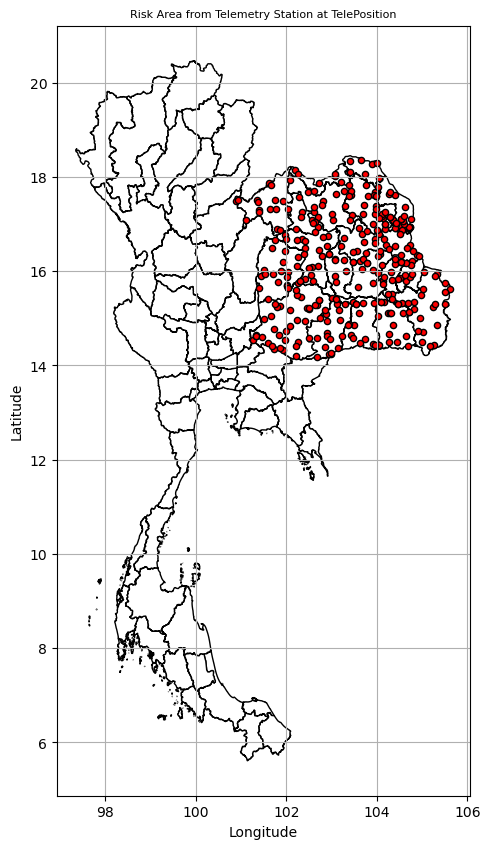

In [5]:
allDf = []
TrainList = []
TestList = []
cc = 0

# Build a KDTree for smapDf locations
smap_locations = points[['latitude', 'longitude']].to_numpy()
print(len(smap_locations))

lenLat = len(points['latitude'].unique())
lenLon = len(points['longitude'].unique())


lat_grid = np.linspace(points['latitude'].min(), points['latitude'].max(), max(lenLat,lenLon))
lon_grid = np.linspace(points['longitude'].min(), points['longitude'].max(), max(lenLat,lenLon))
grid_lat, grid_lon = np.meshgrid(lat_grid, lon_grid)

min_max_scaler = MinMaxScaler()
first_round = True

for combined_file in h5_files:
    #print(combined_file)
    soil_moisture, latitude, longitude = load_combined_file(combined_file)
    soil_moisture = np.ma.masked_invalid(soil_moisture)
    p_name = combined_file.replace(smap_dir+"/","")
    p_name = p_name.replace(".h5","")
    p_name = p_name[:10].replace("-","")
    #print(p_name)

    humidDf= ReadData(tele_humid_dir+p_name+".csv", latitude, longitude, True)
    humidDf = humidDf.reset_index(drop=True)
    #print(humidDf)

    rainDf= ReadData(tele_rain_dir+p_name+".csv", latitude, longitude)
    rainDf = rainDf.reset_index(drop=True)
    #print(rainDf)
    
    smapDf = pd.DataFrame(columns=['latitude','longitude','val'])
    smapDf['latitude'] = latitude
    smapDf['longitude'] = longitude
    smapDf['val'] = soil_moisture

    # Convert Data to spatial with Interpolate then convert back to lat long dataframe
    rainLatLng = interpolate_feature(rainDf, 'val')
    humidLatLng = interpolate_feature(humidDf, 'val')
    
    #print(smapDf[:10])
    
    smapDf = genSMAP(smapDf, smap_locations, points, "val")
    smapDf = genSMAP(rainLatLng, smap_locations, smapDf, "rain")
    smapDf = genSMAP(humidLatLng, smap_locations, smapDf, "humid")
    
    break

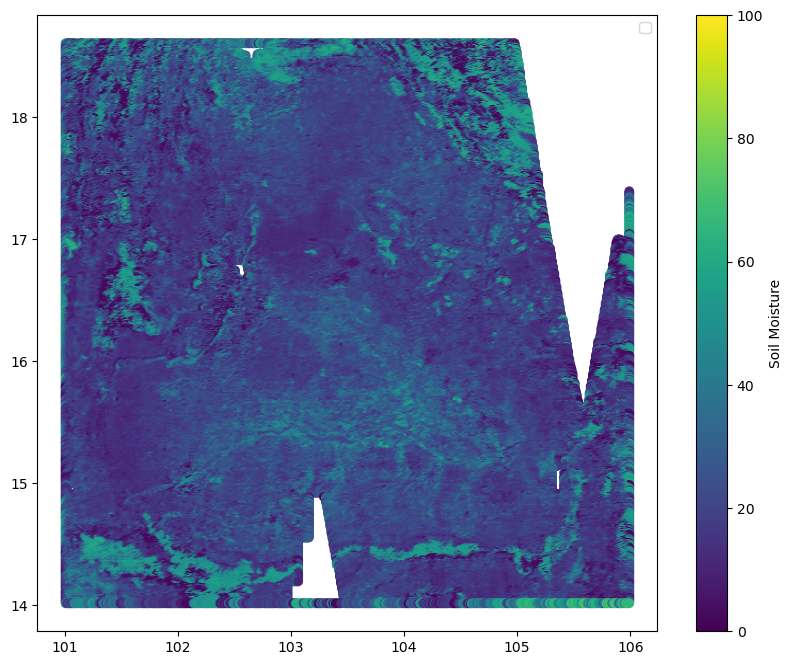

In [6]:
plt.figure(figsize=(10,8))
plt.scatter(smapDf['longitude'], smapDf['latitude'], c=smapDf['val']*100, cmap='viridis', vmin=0, vmax=100)
plt.colorbar(label='Soil Moisture')
plt.legend()
plt.show()


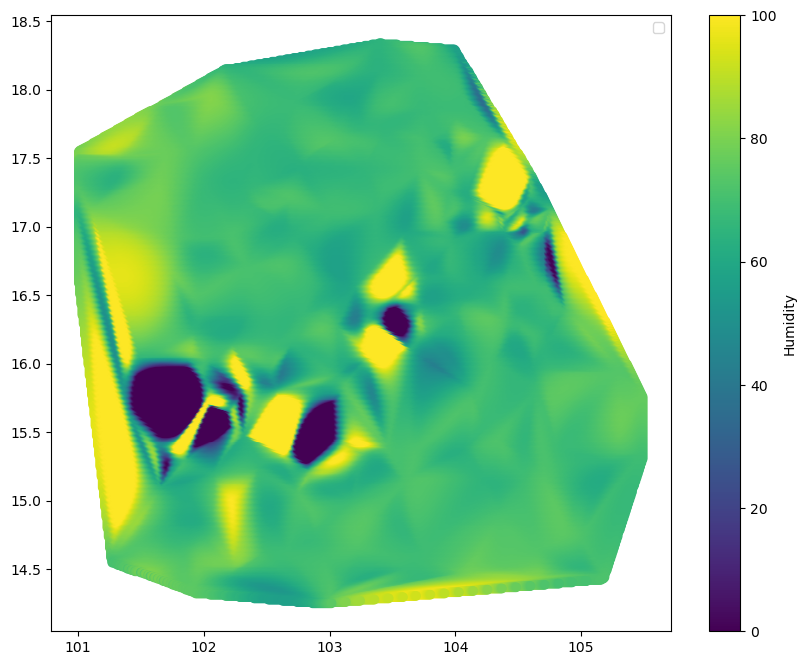

In [9]:
plt.figure(figsize=(10,8))
plt.scatter(smapDf['longitude'], smapDf['latitude'], c=smapDf['humid'], cmap='viridis', vmin=0, vmax=100)
plt.colorbar(label='Humidity')
plt.legend()
plt.show()


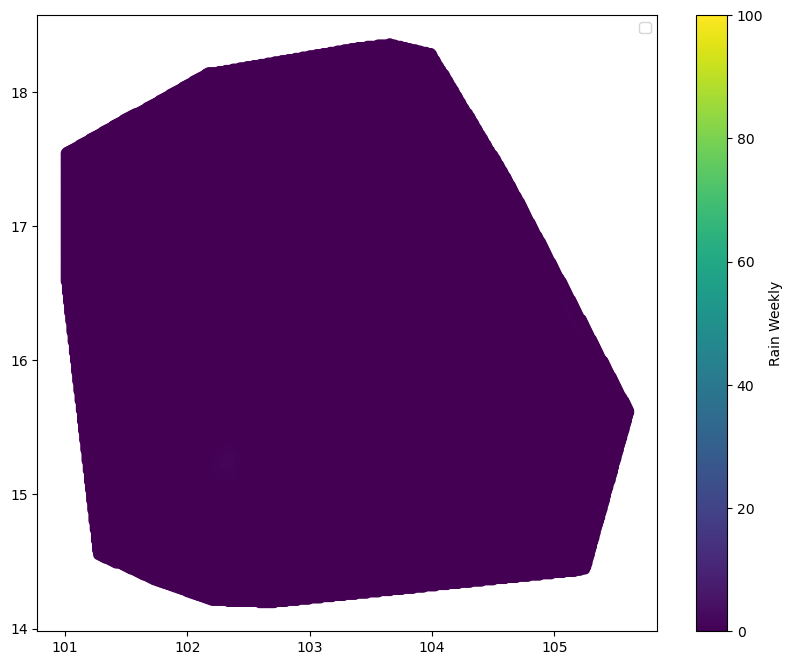

In [11]:
plt.figure(figsize=(10,8))
plt.scatter(smapDf['longitude'], smapDf['latitude'], c=smapDf['rain'], cmap='viridis', vmin=0, vmax=100)
plt.colorbar(label='Rain Weekly')
plt.legend()
plt.show()

In [24]:
df_imputed_mice = smapDf[['val','rain','humid']].copy()

# Initialize IterativeImputer
# estimator can be LinearRegression, RandomForestRegressor, BayesianRidge, etc.
#imputer = IterativeImputer(estimator=BayesianRidge(), max_iter=10, random_state=42)
imputer = IterativeImputer(estimator=BayesianRidge(), max_iter=10, random_state=42)

# Apply imputation to the DataFrame
# IterativeImputer works on the entire DataFrame, so it will impute 'val1'
# based on 'val2' and 'val3' (and potentially other columns if they existed)
df_imputed_mice_array = imputer.fit_transform(df_imputed_mice)
df_imputed_mice = pd.DataFrame(df_imputed_mice_array, columns=df_imputed_mice.columns)


print("\nDataFrame after Iterative Imputation (MICE):")
print(df_imputed_mice)
print("\nMissing values after Iterative Imputation (MICE):")
print(df_imputed_mice.isnull().sum())



DataFrame after Iterative Imputation (MICE):
             val      rain      humid
0       0.480000  0.022117  69.131815
1       0.649764  0.031408  69.762120
2       0.020000 -0.003061  67.423916
3       0.283000  0.011334  68.400389
4       0.046000 -0.001638  67.520449
...          ...       ...        ...
269819  0.381000  0.016698  68.764245
269820  0.708679  0.034633  69.980861
269821  0.632170  0.030445  69.696795
269822  0.675283  0.032805  69.856867
269823  0.655333  0.031713  69.782797

[269824 rows x 3 columns]

Missing values after Iterative Imputation (MICE):
val      0
rain     0
humid    0
dtype: int64


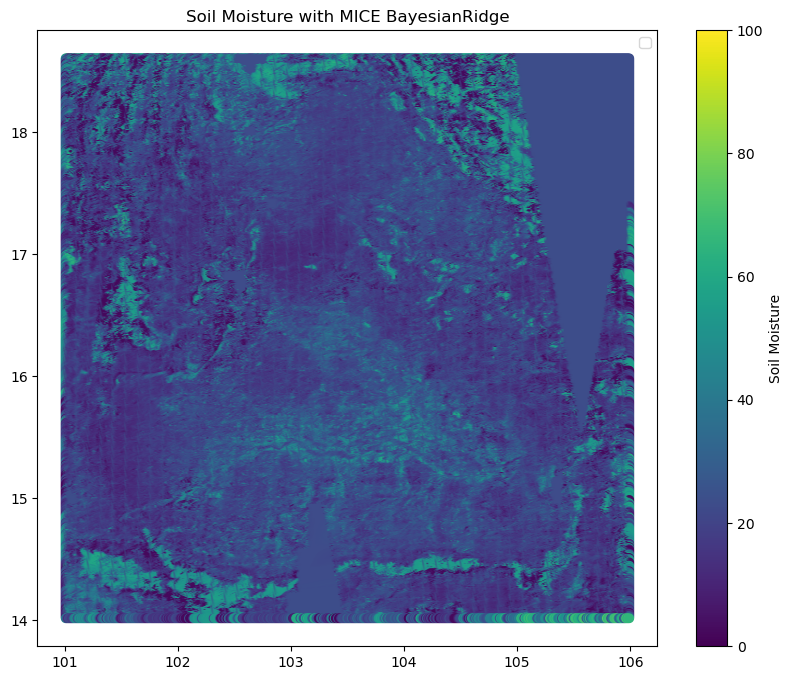

In [25]:
plt.figure(figsize=(10,8))
plt.scatter(smapDf['longitude'], smapDf['latitude'], c=df_imputed_mice['val']*100, cmap='viridis', vmin=0, vmax=100)
plt.colorbar(label='Soil Moisture')
plt.title('Soil Moisture with MICE BayesianRidge')
plt.legend()
plt.savefig(f"./Img/MICE_Impute_with_BayesianRidge.png", dpi=300, bbox_inches='tight')
plt.show()